In [1]:
from htrc_features import FeatureReader
import numpy as np
import pandas as pd

In [2]:
def get_htrc_page_data(document):
    fr = FeatureReader([document])
    vol = next(fr.volumes())
    ptc = vol.tokenlist(pos=False, case=False).reset_index().drop(['section'], axis=1)
    page_list = set(ptc['page'])
    
    # extract tokens by page 
    tokens=list()
    for page in page_list:
        page_data = str()
        
        # operate on each token
        for page_tokens in ptc.loc[ptc['page'] == page].iterrows():
            if page_tokens[1][1].isalpha():
                
                # deal with frequency count by creating correct number of tokens
                page_data += (' '.join([page_tokens[1][1]] * page_tokens[1][2])) + " "

        tokens.append(page_data.split())
    return tokens

In [3]:
# htids for two classes 
chase_novels = ["mdp.39015004308212",
                "mdp.39015024849682",
                "coo.31924014522449"]
jewett_novels = ["uc1.32106015388678",
                "uc2.ark:/13960/t9w08xb8w",
                "uiug.30112012873441"]

In [4]:
# create labels for classifier
labels = ["chase"] * len(chase_novels) + ["jewett"] * len(jewett_novels)

In [5]:
# construct text for consumption into dtm
raw_data = list()
for doc in chase_novels + jewett_novels:
    page_data = get_htrc_page_data(doc)
    tokens = ' '.join([w for p in page_data for w in p])
    raw_data.append(tokens)

/Users/jed/miniforge3/envs/cv/lib/python3.9/site-packages/htrc_features/feature_reader.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.reset_index().groupby(groups).sum()[['count']]
/Users/jed/miniforge3/envs/cv/lib/python3.9/site-packages/htrc_features/feature_reader.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.reset_index().groupby(groups).sum()[['count']]
/Users/jed/miniforge3/envs/cv/lib/python3.9/site-packages/htrc_features/feature_reader.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only wil

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
vec = CountVectorizer(input='content',
                             stop_words='english',
                             strip_accents='unicode')

In [8]:
dtm = vec.fit_transform(raw_data)
dtm_dense = dtm.todense()
dc, vc = dtm.shape
idx2voc = {v:k for k, v in vec.vocabulary_.items()}

In [9]:
def term_debug(term):
    idx = vec.vocabulary_[term]
    print("total count: {0}".format(int(np.sum(dtm,axis=0)[:, idx])))
    print("class 0: {0}".format(count_matrix[0,idx]))
    print("class 1: {0}".format(count_matrix[1,idx]))

In [10]:
# create priors and initialize matrices
priors = np.array([0.1 for i in range(vc)])
z_scores = np.empty(priors.shape[0])
count_matrix = np.empty([2, vc], dtype=np.float32)

# Summarize Class 0
count_matrix[0, :] = np.sum((dtm[0],dtm[2],dtm[3]),axis = 0).todense()

# Summarize Class 1
count_matrix[1, :] = np.sum((dtm[1],dtm[4],dtm[5]),axis = 0).todense()

In [11]:
a0 = np.sum(priors)
n1 = 1.*np.sum(count_matrix[0,:])
n2 = 1.*np.sum(count_matrix[1,:])

In [12]:
for i in range(vc):
    # compute delta
    term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
    term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
    delta = term1 - term2
    
    # compute variance on delta
    var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
    
    # store final score
    z_scores[i] = delta / np.sqrt(var)

In [13]:
# extract most significant terms
[(idx2voc[i], z_scores[i]) for i in np.argsort(z_scores)][:50]

[('miss', -12.430120761891875),
 ('doctor', -9.573802249109717),
 ('child', -8.870578410248033),
 ('good', -8.82346405248881),
 ('ann', -8.357675458654734),
 ('aunt', -8.086594420119788),
 ('prince', -7.259807593831658),
 ('river', -7.18199594960881),
 ('girl', -7.052544121405737),
 ('anna', -6.967481036268088),
 ('philip', -6.910298837426786),
 ('friend', -6.867151959360235),
 ('jan', -6.68345054996112),
 ('said', -6.560858832286338),
 ('ye', -6.548884390264933),
 ('windswept', -6.436511317660012),
 ('used', -6.314467963137244),
 ('deal', -6.239289153157161),
 ('believe', -6.015664120818941),
 ('little', -5.950622144180812),
 ('french', -5.719083290963293),
 ('think', -5.691815102119885),
 ('study', -5.689951129035667),
 ('friends', -5.441316230074467),
 ('story', -5.3703258169807695),
 ('sister', -5.341568189874462),
 ('old', -5.310841602349253),
 ('shall', -5.30313954245451),
 ('caleb', -5.292765356631932),
 ('wish', -5.118284529887115),
 ('stories', -5.114915998315757),
 ('people',

In [14]:
# calculate absolute differences between our first and second text and display
# top twenty-five terms with the greatest difference. 
abs_diff = np.abs(dtm[0] - dtm[1])
for i in np.argsort(abs_diff.toarray()[0])[::-1][:25]:
    print("{0}: {1}".format(idx2voc[i],abs_diff.toarray()[0][i]))

jan: 606
marston: 365
reuben: 363
john: 358
nicholas: 323
silas: 300
anton: 272
said: 267
philip: 235
philomena: 211
susan: 204
solace: 195
dan: 194
like: 176
adrienne: 173
saturday: 172
deborah: 172
windswept: 171
crockett: 158
eileen: 155
julian: 139
huldah: 136
good: 132
haskell: 126
thought: 123


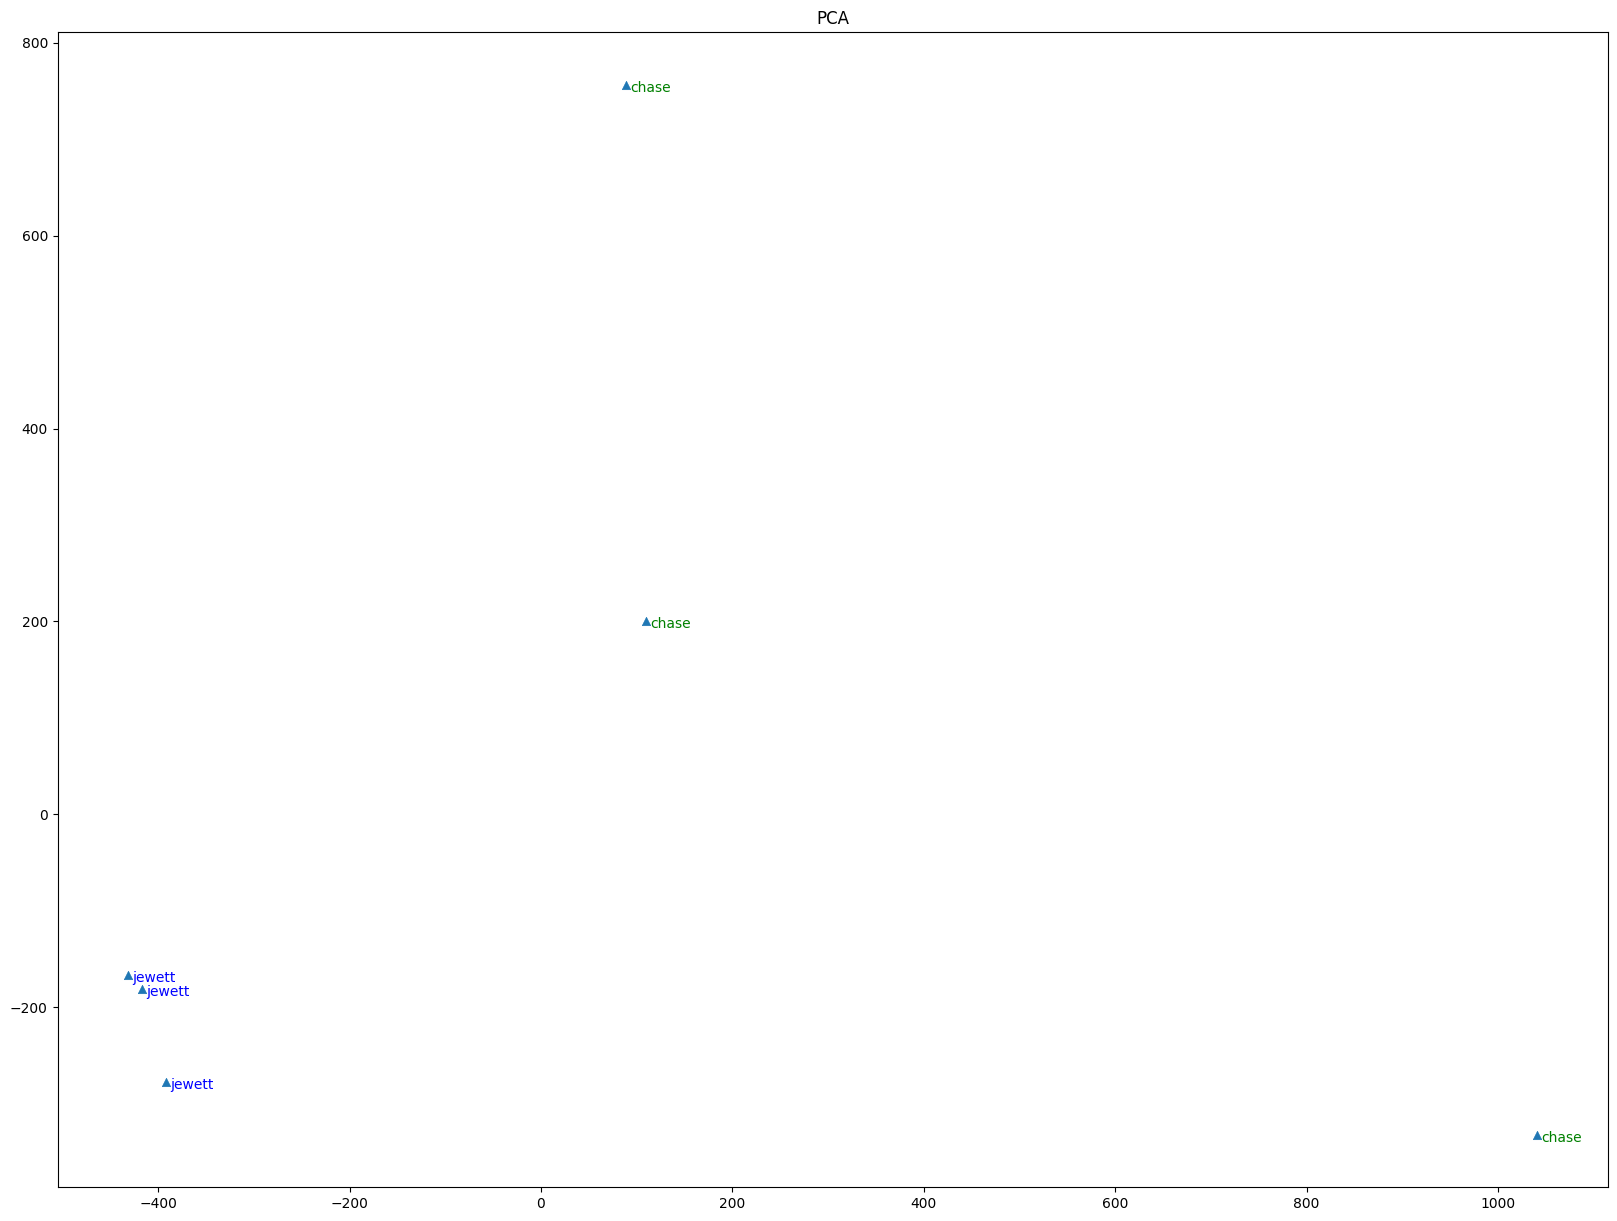

In [16]:
# simple PCA on DTM data
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # two components for plotting
plot_data = pca.fit_transform(np.asarray(dtm_dense))

from matplotlib import pyplot as plt
xs, ys = plot_data[:, 0], plot_data[:, 1]
fig = plt.figure(figsize=(20, 15))
plt.clf()
plt.title("PCA")
plt.style.use('ggplot')
plt.scatter(xs, ys, marker = '^')
cdict = {'chase': 'green', 'jewett': 'blue'}
for i, w in enumerate(labels):
    plt.annotate(w, xy = (xs[i], ys[i]), xytext = (3, 3),
                 textcoords = 'offset points', ha = 'left', va = 'top', c = cdict[labels[i]])
plt.show()

In [15]:
term_debug('society')

total count: 66
class 0: 15.0
class 1: 51.0


In [17]:
term_debug('sea')

total count: 573
class 0: 344.0
class 1: 229.0


In [18]:
term_debug('mother')

total count: 803
class 0: 484.0
class 1: 319.0
